<div style='text-align: right'><i>2022-08</i></div>


<div style='background-color: rgba(76, 175, 80, 0.3)'>

# ML for predict rent value

Predict the rent value from associated attributes.

</div>

# Load libraries and define auxiliary functions
___

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18
plt.rc('font', size=SMALL_SIZE)          
plt.rc('axes', titlesize=SMALL_SIZE)     
plt.rc('axes', labelsize=MEDIUM_SIZE)    
plt.rc('xtick', labelsize=SMALL_SIZE)    
plt.rc('ytick', labelsize=SMALL_SIZE)    
plt.rc('legend', fontsize=SMALL_SIZE)    
plt.rc('figure', titlesize=BIGGER_SIZE)
np.random.seed(42)

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from scipy.stats import randint

import os

# About Dataset
___

Houses to rent data (2020).

### Description
This dataset contains 10962 houses to rent with 13 diferent features.


### FAQ

**Outliers**

Could be some values in dataset that can be consider outlier to analysis. Bearing in mind that a Web Crawler only to get the data, it´s possible find some errors like registration error.

**Changes in data between versions of dataset**

Since the o WebCrawler was runned in differents days to each version of dataset, there may be differences like adding or deleting houses (in addition to the cities added).

I do not own any of these data, they were all taken from information available for free on the internet and compiled just for easy access.

**Download dataset and description above:** https://www.kaggle.com/datasets/rubenssjr/brasilian-houses-to-rent


# Load Dataset
___

In [2]:
# auxiliary functions
path = os.path.join('datasets', 'rents-brazil')
def load_dataset(path=path):
    csv_path = os.path.join(path, 'houses_to_rent_v2.csv')
    return pd.read_csv(csv_path)

In [3]:
dataset = load_dataset()
dataset

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
0,São Paulo,70,2,1,1,7,acept,furnished,2065,3300,211,42,5618
1,São Paulo,320,4,4,0,20,acept,not furnished,1200,4960,1750,63,7973
2,Porto Alegre,80,1,1,1,6,acept,not furnished,1000,2800,0,41,3841
3,Porto Alegre,51,2,1,0,2,acept,not furnished,270,1112,22,17,1421
4,São Paulo,25,1,1,0,1,not acept,not furnished,0,800,25,11,836
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10687,Porto Alegre,63,2,1,1,5,not acept,furnished,402,1478,24,22,1926
10688,São Paulo,285,4,4,4,17,acept,not furnished,3100,15000,973,191,19260
10689,Rio de Janeiro,70,3,3,0,8,not acept,furnished,980,6000,332,78,7390
10690,Rio de Janeiro,120,2,2,2,8,acept,furnished,1585,12000,279,155,14020


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10692 entries, 0 to 10691
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   city                 10692 non-null  object
 1   area                 10692 non-null  int64 
 2   rooms                10692 non-null  int64 
 3   bathroom             10692 non-null  int64 
 4   parking spaces       10692 non-null  int64 
 5   floor                10692 non-null  object
 6   animal               10692 non-null  object
 7   furniture            10692 non-null  object
 8   hoa (R$)             10692 non-null  int64 
 9   rent amount (R$)     10692 non-null  int64 
 10  property tax (R$)    10692 non-null  int64 
 11  fire insurance (R$)  10692 non-null  int64 
 12  total (R$)           10692 non-null  int64 
dtypes: int64(9), object(4)
memory usage: 1.1+ MB


<a id='var_descriptions'></a>

## Features:
  - `city`: city where the property is located
  - `area`: property area
  - `rooms`: n. of rooms
  - `bathroom`: n. of bathrooms
  - `parking spaces`: n. of spaces available in "garage"
  - `floor` - What is the floor?
  - `animal` - Do you accept animals?
  - `furniture` - furniture? (there are table, chair, etc.)
  - `hoa`: Homeowners association tax (condominium fee)
  - `property tax` - IPTU / property tax
  - `rent amount` - rental price
  - `fire insurance` - fire insurance
  - `total`: total value
  
[Go ahead](#add_features).

# Explore dataset
___

## Attribute `total (R$)`

### Question:

Is the rent total value `total` equal the sum of `rent amount` plus `property tax` plus `fire insurance` ?

In [5]:
valor_total = dataset['hoa (R$)'] + dataset['rent amount (R$)'] + \
              dataset['property tax (R$)'] + dataset['fire insurance (R$)']

diff_total = dataset['total (R$)'] - valor_total
diff = dataset.copy()
diff['diff'] = diff_total

diff.head()

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$),diff
0,São Paulo,70,2,1,1,7,acept,furnished,2065,3300,211,42,5618,0
1,São Paulo,320,4,4,0,20,acept,not furnished,1200,4960,1750,63,7973,0
2,Porto Alegre,80,1,1,1,6,acept,not furnished,1000,2800,0,41,3841,0
3,Porto Alegre,51,2,1,0,2,acept,not furnished,270,1112,22,17,1421,0
4,São Paulo,25,1,1,0,1,not acept,not furnished,0,800,25,11,836,0


In [6]:
diff['diff'].value_counts()/len(diff)

 0      0.874205
-1      0.018331
 4      0.015152
-3      0.014310
 2      0.013562
 5      0.013562
 3      0.013094
-2      0.012346
-4      0.012252
 1      0.011504
-5      0.000187
 116    0.000187
-6      0.000187
-7      0.000187
 108    0.000187
 9      0.000094
 12     0.000094
 300    0.000094
 379    0.000094
 47     0.000094
-22     0.000094
 354    0.000094
 22     0.000094
Name: diff, dtype: float64

In [7]:
diff['diff'].value_counts()[1:].sum()

1345

**Conclusion about the question:**

For approximately `87,4%` of the dataset the answer is `YES`. There are `1345` of the total `10692` samples that this occur.

___

### Other attributes

In [8]:
dataset['city'].value_counts()

São Paulo         5887
Rio de Janeiro    1501
Belo Horizonte    1258
Porto Alegre      1193
Campinas           853
Name: city, dtype: int64

In [9]:
dataset.describe()

,area,rooms,bathroom,parking spaces,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
count,10692.000000,10692.000000,10692.000000,10692.000000,1.069200e+04,10692.000000,10692.000000,10692.000000,1.069200e+04
mean,149.217920,2.506079,2.236813,1.609147,1.174022e+03,3896.247194,366.704358,53.300879,5.490487e+03
std,537.016942,1.171266,1.407198,1.589521,1.559231e+04,3408.545518,3107.832321,47.768031,1.648473e+04
min,11.000000,1.000000,1.000000,0.000000,0.000000e+00,450.000000,0.000000,3.000000,4.990000e+02
25%,56.000000,2.000000,1.000000,0.000000,1.700000e+02,1530.000000,38.000000,21.000000,2.061750e+03
50%,90.000000,2.000000,2.000000,1.000000,5.600000e+02,2661.000000,125.000000,36.000000,3.581500e+03
75%,182.000000,3.000000,3.000000,2.000000,1.237500e+03,5000.000000,375.000000,68.000000,6.768000e+03
max,46335.000000,13.000000,10.000000,12.000000,1.117000e+06,45000.000000,313700.000000,677.000000,1.120000e+06


The mean value of rent, without the fees, is approximately `R$ 2661`. However the range of rents cover the minimum of `R$ 450` and maximum of `R$ 45000`. How the 75th-percentile is `R$5000`, rents with more than this value is a minority. Probably high rent values corresponde to comercial property (<span style='color:red'>we can investigate this</span>).

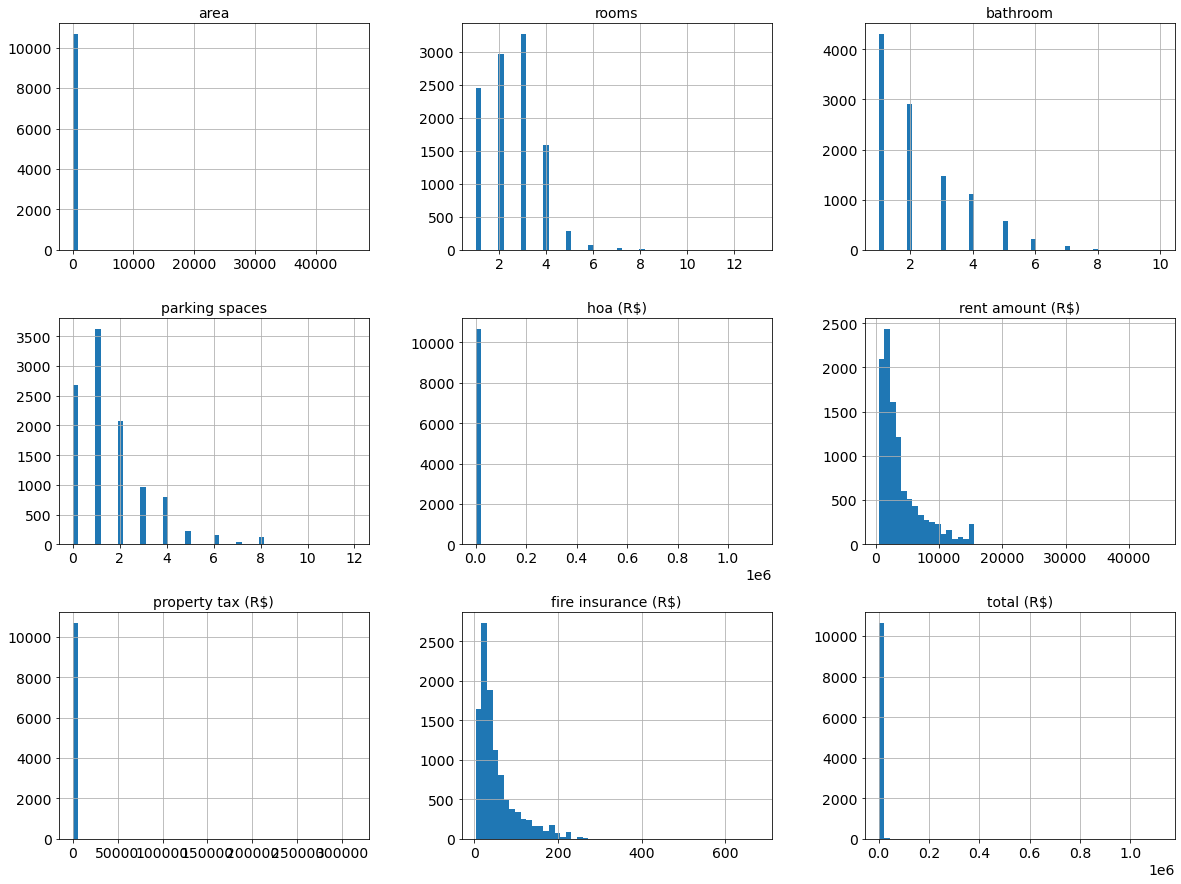

In [10]:
dataset.hist(bins=50, figsize=(20,15))
plt.show()

By the histogram, all attributes have a skewed distribution. In fact, most them have a right-skewed distribution.

# Correlation Analysis

___

In [11]:
dataset.head(3)

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
0,São Paulo,70,2,1,1,7,acept,furnished,2065,3300,211,42,5618
1,São Paulo,320,4,4,0,20,acept,not furnished,1200,4960,1750,63,7973
2,Porto Alegre,80,1,1,1,6,acept,not furnished,1000,2800,0,41,3841


In [12]:
#help(dataset.corr)

In [13]:
# compute correlation matrix for all dataset
corr_matrix = dataset.corr()

In [14]:
# sort by total rent
corr_matrix['total (R$)'].sort_values(ascending=False)

total (R$)             1.000000
hoa (R$)               0.955024
rent amount (R$)       0.264490
fire insurance (R$)    0.254911
property tax (R$)      0.218344
bathroom               0.208339
parking spaces         0.148684
rooms                  0.134597
area                   0.051799
Name: total (R$), dtype: float64

 - The `total rent` have a high correlation with the attribute `hoa` (condominium fee). Maybe `hoa` value is a percentage of the rent.

- Attributes `rent amount`, `fire insurance` and `property tax` also are considerably correlated with `total rent`.

In [15]:
# sort by rent amount
corr_matrix['rent amount (R$)'].sort_values(ascending=False)

rent amount (R$)       1.000000
fire insurance (R$)    0.987343
bathroom               0.668504
parking spaces         0.578361
rooms                  0.541758
total (R$)             0.264490
area                   0.180742
property tax (R$)      0.107884
hoa (R$)               0.036490
Name: rent amount (R$), dtype: float64

For the `rent amount` the attributes `fire insurance`, `bathroom`, `parking spaces` and `rooms`. All these have the standard correlation coefficients (Pearson correlation) more than `0.5`.

## Split dataset and check homogeneity of Test Set
___

**Note:** A good option for create the test set is use a strategy with StratifiedShuffleSplit:

```bash
  from sklearn.model_selection import StratifiedShuffleSplit
```

In [16]:
train_set, test_set = train_test_split(dataset, test_size=0.2, random_state=42)

In [17]:
print('Samples in Training Set:', len(train_set))
print('Samples in Test Set:', len(test_set))

Samples in Training Set: 8553
Samples in Test Set: 2139


### Stratification

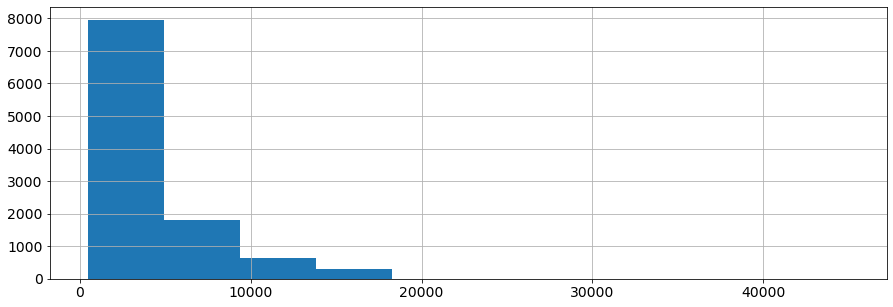

In [18]:
dataset['rent amount (R$)'].hist(figsize=(15, 5))
plt.show()

In [19]:
dataset['rent_amount_category'] = pd.cut(dataset['rent amount (R$)'],
                                         bins=[0., 3000.0, 6000.0, 9000.0, 12000.0, np.inf],
                                         labels=[1, 2, 3, 4, 5])

In [20]:
dataset['rent_amount_category'].value_counts()

1    6061
2    2633
3    1034
4     523
5     441
Name: rent_amount_category, dtype: int64

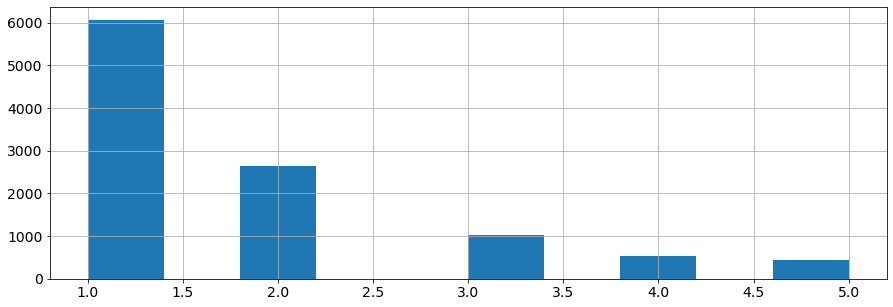

In [21]:
dataset['rent_amount_category'].hist(figsize=(15, 5))
plt.show()

In [22]:
dataset.head()

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$),rent_amount_category
0,São Paulo,70,2,1,1,7,acept,furnished,2065,3300,211,42,5618,2
1,São Paulo,320,4,4,0,20,acept,not furnished,1200,4960,1750,63,7973,2
2,Porto Alegre,80,1,1,1,6,acept,not furnished,1000,2800,0,41,3841,1
3,Porto Alegre,51,2,1,0,2,acept,not furnished,270,1112,22,17,1421,1
4,São Paulo,25,1,1,0,1,not acept,not furnished,0,800,25,11,836,1


In [23]:
split = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
for train_index, test_index in split.split(dataset, dataset['rent_amount_category']):
    strat_train_set = dataset.loc[train_index]
    strat_test_set = dataset.loc[test_index]

In [24]:
#help(StratifiedShuffleSplit)

In [25]:
strat_test_set['rent_amount_category'].value_counts() / len(strat_test_set)

1    0.566620
2    0.246377
3    0.096774
4    0.049088
5    0.041141
Name: rent_amount_category, dtype: float64

In [26]:
dataset['rent_amount_category'].value_counts() / len(dataset)

1    0.566872
2    0.246259
3    0.096708
4    0.048915
5    0.041246
Name: rent_amount_category, dtype: float64

In [27]:
def income_cat_proportions(data):
    return data['rent_amount_category'].value_counts() / len(data)

train_set, test_set = train_test_split(dataset, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(dataset),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()

compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [28]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.566872,0.566620,0.568022,0.202870,-0.044545
2,0.246259,0.246377,0.253389,2.895550,0.047887
3,0.096708,0.096774,0.093969,-2.831906,0.068634
4,0.048915,0.049088,0.046283,-5.380277,0.354251
5,0.041246,0.041141,0.038336,-7.055557,-0.254744


In [29]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop('rent_amount_category', axis=1, inplace=True)

### Define training set

In [30]:
train_set = strat_train_set.copy()

# Exploring Training Set 
___

In [31]:
train_set.head()

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
6762,Rio de Janeiro,200,2,1,0,-,acept,not furnished,0,3000,0,46,3046
5639,São Paulo,59,2,1,1,1,not acept,not furnished,490,1700,0,22,2212
2098,Belo Horizonte,80,3,2,2,1,acept,furnished,280,2500,126,34,2940
9092,São Paulo,87,2,3,2,1,acept,furnished,1200,3560,492,46,5298
1954,São Paulo,60,1,1,1,-,not acept,not furnished,0,1180,0,18,1198


### NAs or inconsistent values

In [32]:
train_set.isna().sum()

city                   0
area                   0
rooms                  0
bathroom               0
parking spaces         0
floor                  0
animal                 0
furniture              0
hoa (R$)               0
rent amount (R$)       0
property tax (R$)      0
fire insurance (R$)    0
total (R$)             0
dtype: int64

In [33]:
train_set.isin(['-']).sum()

city                      0
area                      0
rooms                     0
bathroom                  0
parking spaces            0
floor                  2014
animal                    0
furniture                 0
hoa (R$)                  0
rent amount (R$)          0
property tax (R$)         0
fire insurance (R$)       0
total (R$)                0
dtype: int64

**Note**: The attribute floor has nonumerical values. We should consider this in a predictive modeling. For simplicity, **we will initially discard this one**.

In [34]:
train_set.drop('floor', axis=1, inplace=True)

In [35]:
train_set.isin(['-']).sum()

city                   0
area                   0
rooms                  0
bathroom               0
parking spaces         0
animal                 0
furniture              0
hoa (R$)               0
rent amount (R$)       0
property tax (R$)      0
fire insurance (R$)    0
total (R$)             0
dtype: int64

In [36]:
train_set.shape

(8553, 12)

### Histogram of target variable

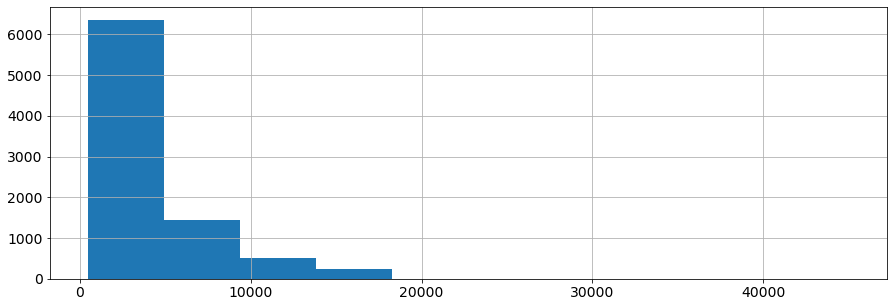

In [37]:
train_set['rent amount (R$)'].hist(figsize=(15, 5))
plt.show()

### Correlation

In [38]:
# compute correlation matrix for training set
corr_mat_train = train_set.corr()
corr_mat_train['rent amount (R$)'].sort_values(ascending=False)

rent amount (R$)       1.000000
fire insurance (R$)    0.986893
bathroom               0.666771
parking spaces         0.574939
rooms                  0.543383
property tax (R$)      0.490425
total (R$)             0.243772
area                   0.165940
hoa (R$)               0.032694
Name: rent amount (R$), dtype: float64

Over again, the attibutes `fire insurance`, `bathroom`, `parking spaces` and `rooms` have the standard Pearson correlation coefficient more than `0.5`.

**Note:** It is worth remembering that a pattern like this can occur with training and test data but not with those that will be updated in a `production environment`.

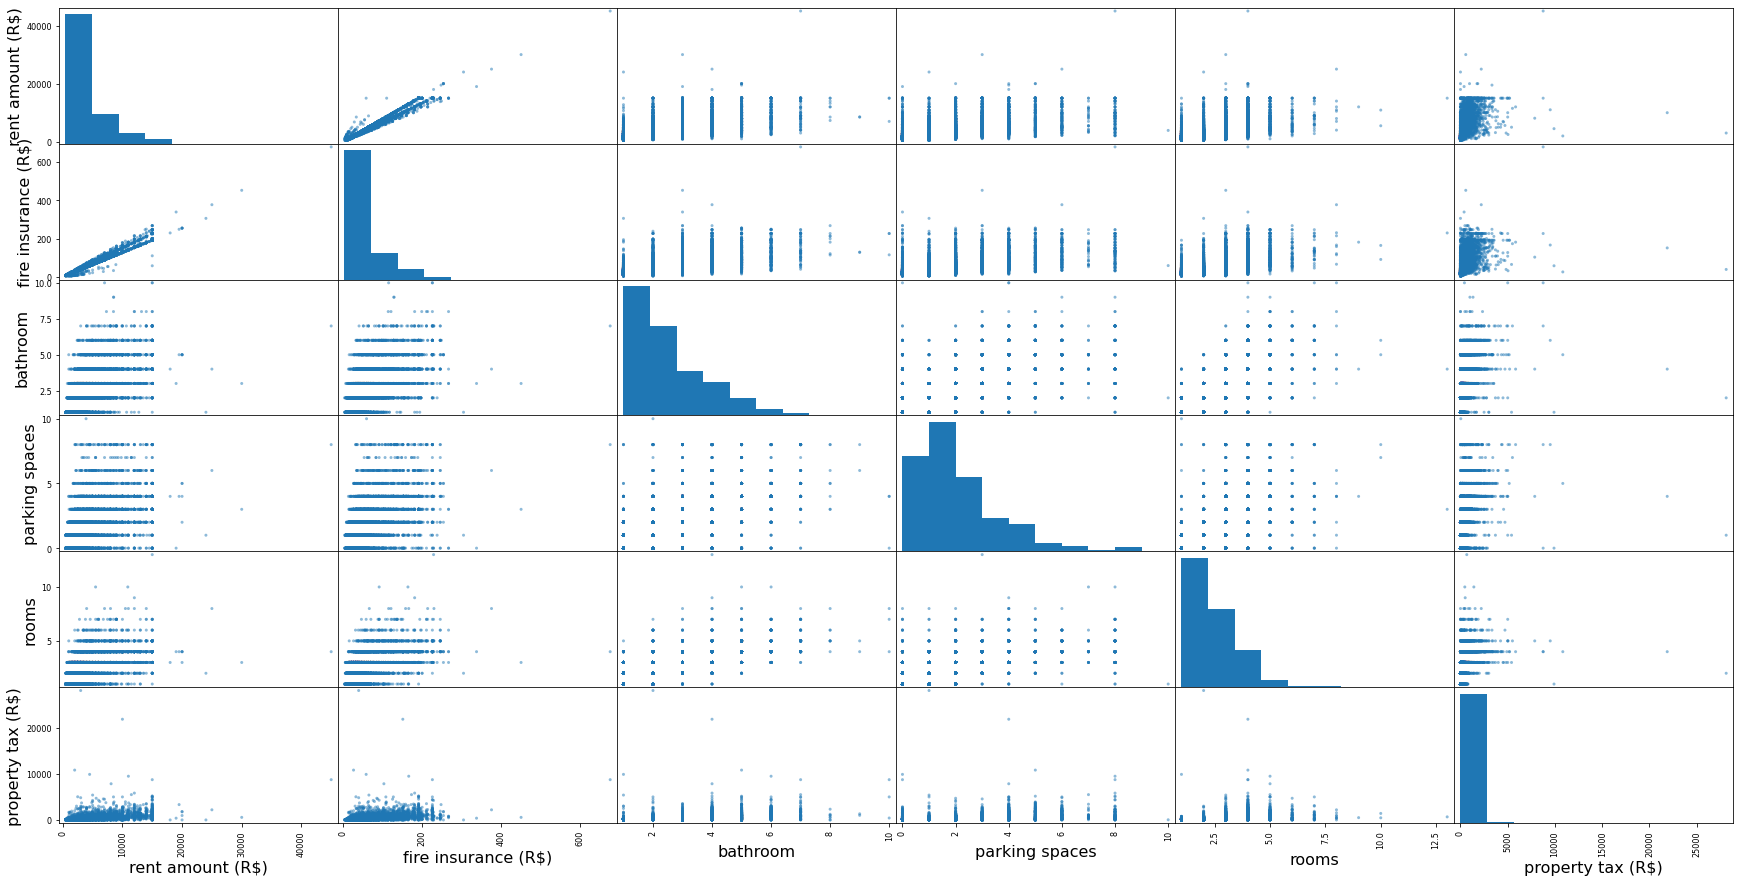

In [39]:
attribs = ['rent amount (R$)', 'fire insurance (R$)', 
           'bathroom', 'parking spaces', 
           'rooms', 'property tax (R$)']
scatter_matrix(train_set[attribs], figsize=(30, 15))
plt.show()

In [40]:
train_set.describe()

,area,rooms,bathroom,parking spaces,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
count,8553.000000,8553.000000,8553.000000,8553.000000,8.553000e+03,8553.000000,8553.000000,8553.000000,8.553000e+03
mean,151.573483,2.508593,2.233953,1.600140,1.225731e+03,3898.140419,337.448264,53.392845,5.514940e+03
std,596.686290,1.171737,1.399204,1.579455,1.742238e+04,3421.416350,701.488247,48.083458,1.797822e+04
min,11.000000,1.000000,1.000000,0.000000,0.000000e+00,450.000000,0.000000,3.000000,4.990000e+02
25%,56.000000,2.000000,1.000000,0.000000,1.570000e+02,1520.000000,38.000000,21.000000,2.067000e+03
50%,90.000000,2.000000,2.000000,1.000000,5.500000e+02,2650.000000,125.000000,36.000000,3.586000e+03
75%,182.000000,3.000000,3.000000,2.000000,1.200000e+03,5000.000000,375.000000,68.000000,6.764000e+03
max,46335.000000,13.000000,10.000000,10.000000,1.117000e+06,45000.000000,28120.000000,677.000000,1.120000e+06


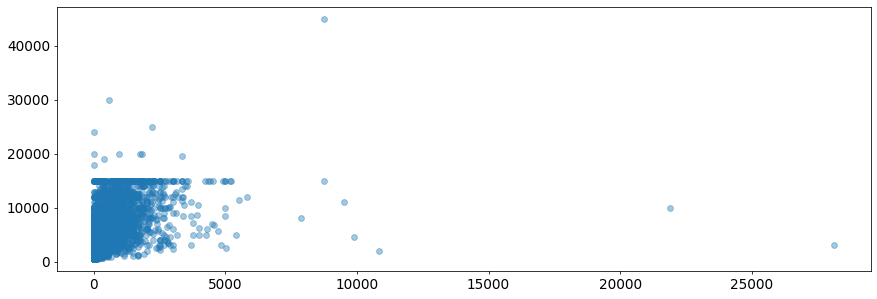

In [41]:
plt.figure(figsize=(15, 5), dpi=70)
plt.scatter(x=train_set['property tax (R$)'], y=train_set['rent amount (R$)'], alpha=0.4)
plt.show()

___

## Add new features

In [42]:
corr_mat_train['rent amount (R$)'].sort_values(ascending=False)

rent amount (R$)       1.000000
fire insurance (R$)    0.986893
bathroom               0.666771
parking spaces         0.574939
rooms                  0.543383
property tax (R$)      0.490425
total (R$)             0.243772
area                   0.165940
hoa (R$)               0.032694
Name: rent amount (R$), dtype: float64

In [43]:
corr_mat_train.style.background_gradient(cmap='BrBG_r')

,area,rooms,bathroom,parking spaces,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
area,1.000000,0.179784,0.213165,0.178004,0.005276,0.165940,0.172848,0.172340,0.043900
rooms,0.179784,1.000000,0.735776,0.614788,0.002472,0.543383,0.387862,0.567105,0.122458
bathroom,0.213165,0.735776,1.000000,0.689434,0.048337,0.666771,0.489863,0.674617,0.194660
parking spaces,0.178004,0.614788,0.689434,1.000000,0.004350,0.574939,0.440574,0.593417,0.132410
hoa (R$),0.005276,0.002472,0.048337,0.004350,1.000000,0.032694,0.031255,0.026166,0.976688
rent amount (R$),0.165940,0.543383,0.666771,0.574939,0.032694,1.000000,0.490425,0.986893,0.243772
property tax (R$),0.172848,0.387862,0.489863,0.440574,0.031255,0.490425,1.000000,0.482529,0.163934
fire insurance (R$),0.172340,0.567105,0.674617,0.593417,0.026166,0.986893,0.482529,1.000000,0.234678
total (R$),0.043900,0.122458,0.194660,0.132410,0.976688,0.243772,0.163934,0.234678,1.000000


<a id='add_features'></a>

Click [here](#var_descriptions) for remember description of all variables.

In [44]:
# add features
train_set_new = train_set.copy()

train_set_new['hoa_per_bath'] = train_set_new['hoa (R$)']/train_set_new['bathroom']
train_set_new['hoa_per_parking'] = train_set_new['hoa (R$)']/train_set_new['parking spaces']
train_set_new['hoa_per_room'] = train_set_new['hoa (R$)']/train_set_new['rooms']
train_set_new['hoa_per_area'] = train_set_new['hoa (R$)']/train_set_new['area']
train_set_new['hoa_per_all'] = train_set_new['hoa (R$)']/(train_set_new['bathroom'] + train_set_new['rooms'])

train_set_new['tax_per_bath'] = train_set_new['property tax (R$)']/train_set_new['bathroom']
train_set_new['tax_per_parking'] = train_set_new['property tax (R$)']/train_set_new['parking spaces']
train_set_new['tax_per_room'] = train_set_new['property tax (R$)']/train_set_new['rooms']
train_set_new['tax_per_area'] = train_set_new['property tax (R$)']/train_set_new['area']

In [45]:
corr_mat_new = train_set_new.corr()
corr_mat_new['rent amount (R$)'].sort_values(ascending=False)

rent amount (R$)       1.000000
fire insurance (R$)    0.986893
bathroom               0.666771
parking spaces         0.574939
rooms                  0.543383
property tax (R$)      0.490425
tax_per_room           0.345984
tax_per_bath           0.279807
total (R$)             0.243772
tax_per_parking        0.201949
area                   0.165940
tax_per_area           0.148475
hoa_per_parking        0.089405
hoa (R$)               0.032694
hoa_per_bath           0.016506
hoa_per_all            0.012126
hoa_per_room           0.003332
hoa_per_area           0.000138
Name: rent amount (R$), dtype: float64

**Note:** From the new features above, only new variable `hoa_per_parking` increase the old `hoa` correlation with the target. Maybe we can consider others new features combine the actual features or external factor.

# Prediction with machine learning models
___

In [46]:
train_set.columns

Index(['city', 'area', 'rooms', 'bathroom', 'parking spaces', 'animal',
       'furniture', 'hoa (R$)', 'rent amount (R$)', 'property tax (R$)',
       'fire insurance (R$)', 'total (R$)'],
      dtype='object')

In [47]:
train_set.shape

(8553, 12)

## Define X and y for training and test sets

In [48]:
# choose original train_set as features (dropping target y)
y = train_set['rent amount (R$)'].copy()
X = train_set.drop('rent amount (R$)', axis=1)

X_test = strat_test_set.drop(['floor', 'rent amount (R$)'], axis=1)
y_test = strat_test_set['rent amount (R$)'].copy()

# choose train_set plus new features as X (dropping target y)
#X = train_set_new.drop('rent amount (R$)', axis=1)
#y = train_set_new['rent amount (R$)'].copy()

In [49]:
X.head(3)

,city,area,rooms,bathroom,parking spaces,animal,furniture,hoa (R$),property tax (R$),fire insurance (R$),total (R$)
6762,Rio de Janeiro,200,2,1,0,acept,not furnished,0,0,46,3046
5639,São Paulo,59,2,1,1,not acept,not furnished,490,0,22,2212
2098,Belo Horizonte,80,3,2,2,acept,furnished,280,126,34,2940


In [50]:
y.head(3)

6762    3000
5639    1700
2098    2500
Name: rent amount (R$), dtype: int64

## Encode categorical features

In [51]:
X.shape

(8553, 11)

In [52]:
X.columns

Index(['city', 'area', 'rooms', 'bathroom', 'parking spaces', 'animal',
       'furniture', 'hoa (R$)', 'property tax (R$)', 'fire insurance (R$)',
       'total (R$)'],
      dtype='object')

In [53]:
def encode_features(X_encoded=X.copy(), cat_features_list=['city', 'animal', 'furniture']):
  
  # add features encoded  
  print('1: ', X_encoded.shape)
  for attr in cat_features_list:
    encoder = OrdinalEncoder()
    attr_encoded = encoder.fit_transform(X_encoded[[attr]])
    print('length attr_enconded = ', len(attr_encoded))
    print('pd.DataFrame(...).shape = ', 
          pd.DataFrame(data=attr_encoded, columns=[attr+'_code'], dtype=np.int64).shape)    
    X_encoded[attr+'_code'] = attr_encoded
    print('2: ', X_encoded.shape)
    print('>> Attribute "{}" with values "{}" were encoded as "{}".\n'\
          .format(attr, X[attr].unique().tolist(), X_encoded[attr+'_code'].unique().tolist()))
    X_encoded = X_encoded.drop(attr, axis=1)
    print('3: ', X_encoded.shape)

  # divide train set in numerical and categorical parts
  X_num = X_encoded.iloc[:, :-len(cat_features_list)]
  X_cat = X_encoded.iloc[:, -len(cat_features_list):]
  del X_encoded
  return X_num, X_cat

In [54]:
X_num, X_cat = encode_features(X_encoded=X.copy(), cat_features_list=['city', 'animal', 'furniture'])

1:  (8553, 11)
length attr_enconded =  8553
pd.DataFrame(...).shape =  (8553, 1)
2:  (8553, 12)
>> Attribute "city" with values "['Rio de Janeiro', 'São Paulo', 'Belo Horizonte', 'Campinas', 'Porto Alegre']" were encoded as "[3.0, 4.0, 0.0, 1.0, 2.0]".

3:  (8553, 11)
length attr_enconded =  8553
pd.DataFrame(...).shape =  (8553, 1)
2:  (8553, 12)
>> Attribute "animal" with values "['acept', 'not acept']" were encoded as "[0.0, 1.0]".

3:  (8553, 11)
length attr_enconded =  8553
pd.DataFrame(...).shape =  (8553, 1)
2:  (8553, 12)
>> Attribute "furniture" with values "['not furnished', 'furnished']" were encoded as "[1.0, 0.0]".

3:  (8553, 11)


In [55]:
X_num.shape

(8553, 8)

In [56]:
X_cat.shape

(8553, 3)

In [57]:
X_num.head(3)

,area,rooms,bathroom,parking spaces,hoa (R$),property tax (R$),fire insurance (R$),total (R$)
6762,200,2,1,0,0,0,46,3046
5639,59,2,1,1,490,0,22,2212
2098,80,3,2,2,280,126,34,2940


In [58]:
X_cat.head(3)

,city_code,animal_code,furniture_code
6762,3.0,0.0,1.0
5639,4.0,1.0,1.0
2098,0.0,0.0,0.0


## Scale numerical features

In [59]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_num)

StandardScaler()

In [60]:
scaler.transform(X_num)

array([[ 0.08116384, -0.43407627, -0.8819481 , ..., -0.48107434,
        -0.15375926, -0.13733749],
       [-0.15515506, -0.43407627, -0.8819481 , ..., -0.48107434,
        -0.65292059, -0.18372966],
       [-0.11995863,  0.41940748, -0.16721415, ..., -0.30144571,
        -0.40333992, -0.14323386],
       ...,
       [ 0.08116384, -0.43407627,  1.9769877 , ...,  0.85473533,
         2.86200714,  0.72675831],
       [-0.12666271, -0.43407627, -0.16721415, ..., -0.26437949,
        -0.36174315, -0.0834358 ],
       [ 0.08116384,  0.41940748, -0.16721415, ..., -0.23016452,
        -0.38254154, -0.16709746]])

In [61]:
pd.DataFrame(scaler.transform(X_num), columns=X_num.columns, index=X_num.index).shape

(8553, 8)

In [62]:
X_cat.shape

(8553, 3)

In [63]:
 X_prepared = pd.concat([pd.DataFrame(scaler.transform(X_num), columns=X_num.columns, index=X_num.index), 
                         X_cat], 
                        axis=1)

In [64]:
X_prepared

,area,rooms,bathroom,parking spaces,hoa (R$),property tax (R$),fire insurance (R$),total (R$),city_code,animal_code,furniture_code
6762,0.081164,-0.434076,-0.881948,-1.013156,-0.070358,-0.481074,-0.153759,-0.137337,3.0,0.0,1.0
5639,-0.155155,-0.434076,-0.881948,-0.379989,-0.042232,-0.481074,-0.652921,-0.183730,4.0,1.0,1.0
2098,-0.119959,0.419407,-0.167214,0.253178,-0.054286,-0.301446,-0.403340,-0.143234,0.0,0.0,0.0
9092,-0.108226,-0.434076,0.547520,0.253178,-0.001477,0.220333,-0.153759,-0.012068,4.0,0.0,0.0
1954,-0.153479,-1.287560,-0.881948,-0.379989,-0.070358,-0.481074,-0.736114,-0.240135,4.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
6657,-0.161859,-0.434076,-0.881948,-0.379989,-0.056008,-0.362748,-0.652921,-0.203588,2.0,0.0,1.0
10433,-0.158507,-0.434076,-0.167214,-0.379989,-0.041658,-0.281487,-0.008171,-0.037377,4.0,0.0,1.0
9797,0.081164,-0.434076,1.976988,0.253178,0.070159,0.854735,2.862007,0.726758,4.0,1.0,0.0
1240,-0.126663,-0.434076,-0.167214,0.253178,-0.011407,-0.264379,-0.361743,-0.083436,1.0,0.0,0.0


# Training models

___

In [65]:
X_prepared.shape

(8553, 11)

In [66]:
y.shape

(8553,)

## Linear Regression, Decision Tree

In [67]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

model1 = LinearRegression()
model2 = DecisionTreeRegressor(random_state=42)
model3 = RandomForestRegressor(random_state=42)

In [68]:
#help(RandomForestRegressor)

In [69]:
model1.fit(X_prepared, y)
model2.fit(X_prepared, y)
model3.fit(X_prepared, y);

model_list = [model1, model2, model3]

# Predicting some values
___

In [70]:
# select n values of training set
n = 7
some_data = X_prepared[:n]
some_labels = y[:n]

In [71]:
some_pred_df = some_labels.copy()

for model in model_list:
  some_pred = model.predict(some_data)
  name_model = str(model).split('(')[0]
  some_pred_df = pd.concat([pd.DataFrame(some_pred, columns=['pred_'+name_model],
                                         index=some_labels.index),
                            some_pred_df], axis=1)

In [72]:
some_pred_df

,pred_RandomForestRegressor,pred_DecisionTreeRegressor,pred_LinearRegression,rent amount (R$)
6762,2985.00,3000.0,2999.848291,3000
5639,1697.55,1700.0,1699.960661,1700
2098,2487.25,2500.0,2500.072684,2500
9092,3563.16,3560.0,3559.856880,3560
1954,1159.77,1180.0,1179.973338,1180
9463,687.62,700.0,699.840740,700
3359,4197.90,4200.0,4199.555996,4200


# Measure prediction error
___

## Prepare test set

In [73]:
X_test_num, X_test_cat = encode_features(X_test.copy())

1:  (2139, 11)
length attr_enconded =  2139
pd.DataFrame(...).shape =  (2139, 1)
2:  (2139, 12)
>> Attribute "city" with values "['Rio de Janeiro', 'São Paulo', 'Belo Horizonte', 'Campinas', 'Porto Alegre']" were encoded as "[3.0, 0.0, 4.0, 1.0, 2.0]".

3:  (2139, 11)
length attr_enconded =  2139
pd.DataFrame(...).shape =  (2139, 1)
2:  (2139, 12)
>> Attribute "animal" with values "['acept', 'not acept']" were encoded as "[1.0, 0.0]".

3:  (2139, 11)
length attr_enconded =  2139
pd.DataFrame(...).shape =  (2139, 1)
2:  (2139, 12)
>> Attribute "furniture" with values "['not furnished', 'furnished']" were encoded as "[0.0, 1.0]".

3:  (2139, 11)


In [74]:
X_test_prepared = pd.concat([pd.DataFrame(scaler.transform(X_test_num), columns=X_test_num.columns, 
                                          index=X_test_num.index), X_test_cat], axis=1)

## Compute errors

In [75]:
rent_pred_model1 = model1.predict(X_prepared) # prediction over training set
model1_rmse = np.sqrt(mean_squared_error(y, rent_pred_model1))
model1_rmse

6.579409170219907

In [76]:
rent_pred_test_model1 = model1.predict(X_test_prepared) # prediction over training set
model1_rmse_test = np.sqrt(mean_squared_error(y_test, rent_pred_test_model1))
model1_rmse_test

3.703179993250839

In [77]:
model1_mae = mean_absolute_error(y, rent_pred_model1)
model1_mae

0.6344361627995629

In [78]:
def compute_errors(model_list=model_list, X_set=X_prepared.copy(), y_label=y.copy(), label='training set'):
  
  print('Errors for the {}:'.format(label))
  
  table_dict = {'Model': [], 'RMSE': [], 'MAE': []}
  table_pred = pd.DataFrame(data=table_dict)  
  
  for model in model_list:
    name_model = str(model).split('(')[0]    
    y_pred = model.predict(X_set)
    model_rmse = np.sqrt(mean_squared_error(y_label, y_pred))
    model_mae = mean_absolute_error(y_label, y_pred)
    dict_errors = {'Model': [name_model], 'RMSE': [model_rmse], 'MAE': [model_mae]}  
    row_errors = pd.DataFrame(data=dict_errors)
    table_pred = pd.concat([table_pred, row_errors], axis=0)      

  table_pred.reset_index(inplace=True, drop=True)

  return table_pred

In [79]:
# compute training errors
compute_errors()

Errors for the training set:


,Model,RMSE,MAE
0,LinearRegression,6.579409,0.634436
1,DecisionTreeRegressor,0.000000,0.000000
2,RandomForestRegressor,124.665667,24.839358


In [80]:
# compute test errors
compute_errors(X_set=X_test_prepared.copy(), y_label=y_test.copy(), label='test set')

Errors for the test set:


,Model,RMSE,MAE
0,LinearRegression,3.703180,0.610181
1,DecisionTreeRegressor,334.681681,69.629266
2,RandomForestRegressor,213.055941,61.438167


# Tuning the models
___

## Cross-validation

In [81]:
def compute_cv_errors(model_list=model_list, X_set=X_prepared.copy(), y_label=y.copy(), label='training set', cv=10):
  
  print('\nComputing cross-validation errors for the {} ...'.format(label))  
  
  for model in model_list:
    name_model = str(model).split('(')[0]
    print('\n>> Model: ', name_model)    
    y_pred = model.predict(X_set)
    model_scores = cross_val_score(model, X_set, y_label, cv=cv, scoring='neg_mean_squared_error')
    model_rmse_scores = np.sqrt(-model_scores)
    print('\n>  {} scores:\n {}'.format(cv, model_scores.tolist()))
    print('\n>  stats: \n', pd.DataFrame(model_rmse_scores, columns=[name_model]).describe())

  return False

In [82]:
compute_cv_errors()


Computing cross-validation errors for the training set ...

>> Model:  LinearRegression

>  10 scores:
 [-1.2242685555500339, -1.266261660302565, -147.74996237713793, -1.406235359686008, -1.493086516890124, -106.35658037267955, -2.0937869677564453, -168.96604191221383, -1.9347013368616328, -1.123640573727639]

>  stats: 
        LinearRegression
count         10.000000
mean           4.400433
std            5.163724
min            1.060019
25%            1.140424
50%            1.306427
75%            8.096448
max           12.998694

>> Model:  DecisionTreeRegressor

>  10 scores:
 [-109627.3796728972, -63713.667056074766, -54087.15303738318, -159500.4643274854, -547319.2397660819, -118783.29356725146, -205973.56023391814, -74048.13333333333, -91215.86666666667, -32841.23625730994]

>  stats: 
        DecisionTreeRegressor
count              10.000000
mean              350.911938
std               158.366000
min               181.221512
25%               257.341214
50%               

False

**Note:** There are difference between values of np.std() and pd.std(). More details in:

- https://stackoverflow.com/questions/24984178/different-std-in-pandas-vs-numpy

- https://www.youtube.com/watch?v=Cn0skMJ2F3c

See below an example.

In [83]:
x1 = np.array([  1.12345678,   1.11345678, 257.12345678, 1.22345678,
         1.33123456, 107.12345678, 2.12345678, 167.12345678,
         1.44123456,   1.55123456])
x1

array([  1.12345678,   1.11345678, 257.12345678,   1.22345678,
         1.33123456, 107.12345678,   2.12345678, 167.12345678,
         1.44123456,   1.55123456])

In [84]:
def calc_describe(x):
  print("count: ", len(x))
  print("mean: ", np.mean(x))
  print("std: ", np.std(x))
  print("min: ", np.min(x))
  print("25%:", np.percentile(x1, 25))
  print("50%:", np.percentile(x1, 50))
  print("75%:", np.percentile(x1, 75))  
  print("max = ", np.max(x))

In [85]:
calc_describe(x1)

count:  10
mean:  54.12779011400001
std:  87.31250982896698
min:  1.11345678
25%: 1.250401225
50%: 1.49623456
75%: 80.87345678000001
max =  257.12345678


In [86]:
pd.DataFrame(x1).describe()

,0
count,10.000000
mean,54.127790
std,92.035466
min,1.113457
25%,1.250401
50%,1.496235
75%,80.873457
max,257.123457


___

## Cross-Validated Grid-Search

Command:
```bash
>> from sklearn.model_selection import GridSearchCV
```

From your help:

 _`GridSearchCV` implements a "fit" and a "score" method. It also implements "score_samples", "predict", "predict_proba", "decision_function", "transform" and "inverse_transform" if they are implemented in the estimator used. The parameters of the estimator used to apply these methods are optimized by cross-validated grid-search over a parameter grid._

In [87]:
model_list

[LinearRegression(),
 DecisionTreeRegressor(random_state=42),
 RandomForestRegressor(random_state=42)]

## Tuning Random Forest model

In [88]:
#help(model_list[2])

In [89]:
%time

param_grid = [
  # 1st combination: 6x5 = 30 hyperparameters
  {'n_estimators': [2, 10, 50, 100, 150, 200], 'max_features': [2, 4, 6, 8, 10]},
  # 2nd combination: 1x3x4 = 12 hyperparameters
  {'bootstrap': [False], 'n_estimators': [5, 50, 100], 'max_features': [2, 3, 4, 5]},
]

# train over 10 folds: 10*(30+12) = 420 configurations
grid_search = GridSearchCV(estimator=model_list[2], param_grid=param_grid,
                           scoring='neg_mean_squared_error', n_jobs=-1, cv=10,
                           verbose=0, return_train_score=True)
grid_search.fit(X_prepared, y)

CPU times: user 11 µs, sys: 4 µs, total: 15 µs
Wall time: 27.9 µs


GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid=[{'max_features': [2, 4, 6, 8, 10],
                          'n_estimators': [2, 10, 50, 100, 150, 200]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4, 5],
                          'n_estimators': [5, 50, 100]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [90]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 150}

In [91]:
np.sqrt(-grid_search.best_score_)

340.955542676316

In [92]:
grid_search.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_max_features', 'param_n_estimators', 'param_bootstrap', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'split5_train_score', 'split6_train_score', 'split7_train_score', 'split8_train_score', 'split9_train_score', 'mean_train_score', 'std_train_score'])

In [93]:
gridcv_results = grid_search.cv_results_

i = 1
for mean_score, std_score, params in zip(gridcv_results['mean_test_score'],
                                         gridcv_results['std_train_score'],
                                         gridcv_results['params']):
  print('{}) mean_score: {} | std_score: {} | \nparams: {} \n'\
          .format(i, np.sqrt(-mean_score), std_score, params))
  i+=1

1) mean_score: 651.1566275554303 | std_score: 31240.293752320005 | 
params: {'max_features': 2, 'n_estimators': 2} 

2) mean_score: 544.6412694894113 | std_score: 7323.388615400989 | 
params: {'max_features': 2, 'n_estimators': 10} 

3) mean_score: 513.3112679720049 | std_score: 5157.589888686265 | 
params: {'max_features': 2, 'n_estimators': 50} 

4) mean_score: 511.4075671529039 | std_score: 5212.949690207512 | 
params: {'max_features': 2, 'n_estimators': 100} 

5) mean_score: 512.4185456386172 | std_score: 4987.72496530217 | 
params: {'max_features': 2, 'n_estimators': 150} 

6) mean_score: 511.9772607659954 | std_score: 4292.168309119494 | 
params: {'max_features': 2, 'n_estimators': 200} 

7) mean_score: 449.00576975497984 | std_score: 33486.35003909539 | 
params: {'max_features': 4, 'n_estimators': 2} 

8) mean_score: 405.48254195756357 | std_score: 7791.2983805234735 | 
params: {'max_features': 4, 'n_estimators': 10} 

9) mean_score: 401.1647547354871 | std_score: 6141.025816740

## Cross-Validated Randomized Search


Command:
```bash
>> from sklearn.model_selection import RandomizedSearchCV
```

From your help:

 _`RandomizedSearchCV` implements a "fit" and a "score" method. It also implements "score_samples", "predict", "predict_proba",  "decision_function", "transform" and "inverse_transform" if they are implemented in the estimator used. The parameters of the estimator used to apply these methods are optimized by cross-validated search over parameter settings. In contrast to GridSearchCV, not all parameter values are tried out, but rather a fixed number of parameter settings is sampled from the specified distributions. The number of parameter settings that are tried is given by n_iter. If all parameters are presented as a list, sampling without replacement is performed. If at least one parameter is given as a distribution, sampling with replacement is used. It is highly recommended to use continuous distributions for continuous parameters._
 
 
 **Note:** Later try `HalvingRandomSearchCV`:
 https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingGridSearchCV.html#sklearn.model_selection.HalvingGridSearchCV

In [94]:
#help(RandomizedSearchCV)

In [95]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint # uniform discrete random variable

In [96]:
%time

param_distribs = {'n_estimators': randint(low=1, high=200), 'max_features': randint(low=1, high=10)}

random_search = RandomizedSearchCV(estimator=model_list[2], param_distributions=param_distribs, 
                                   n_iter=10, scoring='neg_mean_squared_error',
                                   n_jobs=-1, cv=10, random_state=42)
random_search.fit(X_prepared, y)

CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 3.34 µs


RandomizedSearchCV(cv=10, estimator=RandomForestRegressor(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7efdb85d4790>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7efdb85b0bb0>},
                   random_state=42, scoring='neg_mean_squared_error')

In [97]:
random_search.best_params_

{'max_features': 8, 'n_estimators': 131}

In [98]:
np.sqrt(-random_search.best_score_)

340.71578320960504

Tuning with GridSeacrhCV give a less RMSE error.

In [99]:
# recalculate error with GridSearchCV
np.sqrt(-grid_search.best_score_)

340.955542676316

In [100]:
random_search.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_max_features', 'param_n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [101]:
rscv_results = random_search.cv_results_
i = 1
for mean_score, std_score, params in zip(rscv_results['mean_test_score'], 
                                         rscv_results['std_test_score'], 
                                         rscv_results['params']):
  print('{}) mean_score: {} | std_score: {} | \nparams: {} \n'\
          .format(i, np.sqrt(-mean_score), std_score, params))
  i+=1

1) mean_score: 355.50464708770926 | std_score: 193453.3348656178 | 
params: {'max_features': 7, 'n_estimators': 180} 

2) mean_score: 344.81919758848414 | std_score: 175357.4604316705 | 
params: {'max_features': 8, 'n_estimators': 189} 

3) mean_score: 386.6991430765459 | std_score: 235901.55010728646 | 
params: {'max_features': 5, 'n_estimators': 103} 

4) mean_score: 427.125881731423 | std_score: 279140.5654464101 | 
params: {'max_features': 3, 'n_estimators': 75} 

5) mean_score: 341.7511981559335 | std_score: 169208.41985541093 | 
params: {'max_features': 8, 'n_estimators': 117} 

6) mean_score: 408.820302767913 | std_score: 276120.57168320165 | 
params: {'max_features': 4, 'n_estimators': 104} 

7) mean_score: 340.71578320960504 | std_score: 168036.7920876853 | 
params: {'max_features': 8, 'n_estimators': 131} 

8) mean_score: 362.4780611965562 | std_score: 197605.56943177021 | 
params: {'max_features': 6, 'n_estimators': 53} 

9) mean_score: 513.8705660867596 | std_score: 347774.

# Define final model based on tuning

___

In [102]:
final_model = grid_search.best_estimator_

# prediction over training set
final_preds_train = final_model.predict(X_prepared)
final_rmse_train = np.sqrt(mean_squared_error(y, final_preds_train))
final_mae_train = mean_absolute_error(y, final_preds_train)

# prediction over test set
final_preds = final_model.predict(X_test_prepared)
final_rmse = np.sqrt(mean_squared_error(y_test, final_preds))
final_mae = mean_absolute_error(y_test, final_preds)

print('Model selected: {}.\n'.format(model_list[2]))

print('Final RMSE (training set) =', final_rmse_train)
print('Final MAE (training set) =', final_mae_train)
print('Final RMSE (test set) =', final_rmse)
print('Final MAE (test set) =', final_mae)

Model selected: RandomForestRegressor(random_state=42).

Final RMSE (training set) = 124.39293585597498
Final MAE (training set) = 25.316239136365414
Final RMSE (test set) = 206.0793667739765
Final MAE (test set) = 61.430712170796326


# Next steps:

___

**Add:**

- step with web scraping in some sites

- pipeline with data prep, models, tuning, deploy (outputs in JSON)

-  summary for navigation

- generate a framework picture of the problem/sub-problems (e.g., web scraping, monitoring errors, alerts, etc.).

- something with frameworks (Flask, Django, others)

- new models (e.g. Logistic Regression, LGBM, SVM, etc.)

- maybe try Plotly, Seaborn, Matplotlib(with set params) and others for graphs

